Dropdown(description='Season:', index=3, options=(2016, 2017, 2018, 2019, 2020), value=2019)

Dropdown(description='Team:', index=3, options=('Capitals', 'Penguins', 'Blue Jackets', 'Canadiens', 'Senators…

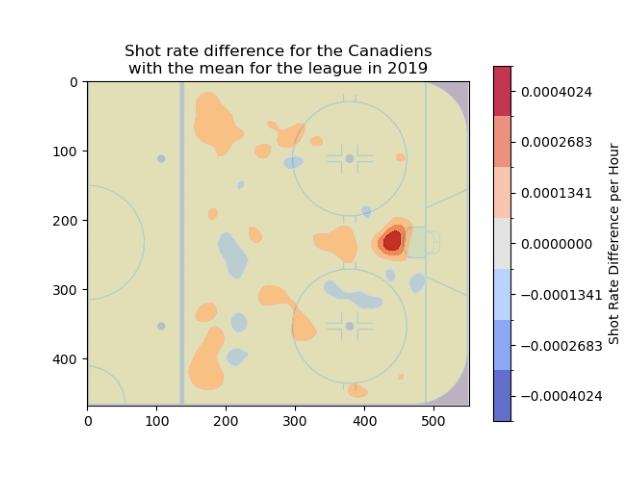

In [ ]:
from ift6758.data import load_events_dataframe
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter
from matplotlib.colors import BoundaryNorm
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import os

rink_width = 550
rink_height = 468
rink_x_min, rink_x_max = 0, 100
rink_y_min, rink_y_max = -42.5, 42.5
rink_image_path = "../figures/nhl_rink_cropped.png"

def how_many_non_zero_elem(matrix):
    num = 0
    list_coord = []
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            elem = matrix[i][j]
            if elem != 0 and elem > 0.0000000000001:
                coord = (i, j, float(elem))
                list_coord.append(coord)
                num += 1
    return num, list_coord

def transform_coordinates(x, y):
    transformed_x = ((x - rink_x_min) / (rink_x_max - rink_x_min)) * rink_width
    transformed_y = rink_height - ((y - rink_y_min) / (rink_y_max - rink_y_min) * rink_height)
    return transformed_x, transformed_y

def get_teams_dict(teams):
    teams_dict = {}
    for i in range(len(teams)):
        teams_dict[teams[i]] = i
    return teams_dict

def put_right_format(array):
    final_matrix = []
    for elem in array:
        new_elem = np.array([[elem] * (551)] * (468))
        final_matrix.append(new_elem)
    return np.array(final_matrix)

def get_adv_visuals(year: int, team: str):
    assert year in [2016, 2017, 2018, 2019, 2020]
    
    teams = [
        'Capitals', 'Penguins', 'Blue Jackets', 'Canadiens', 'Senators',
        'Bruins', 'Rangers', 'Maple Leafs', 'Islanders', 'Lightning',
        'Flyers', 'Hurricanes', 'Panthers', 'Red Wings', 'Sabres',
        'Devils', 'Blackhawks', 'Wild', 'Blues', 'Ducks', 'Oilers',
        'Sharks', 'Flames', 'Predators', 'Jets', 'Kings', 'Stars',
        'Coyotes', 'Canucks', 'Avalanche', 'Golden Knights'
    ]
    num_teams = len(teams)

    teams_dict = get_teams_dict(teams)

    # Define file path for the image
    filepath = f'../figures/{year}_{team}.png'
    
    # Check if the image already exists
    if os.path.exists(filepath):
        return filepath

    df = load_events_dataframe(year)
    df = df.query('zone_code == "O" or (zone_code == "N" and x_coord*goal_x_coord >= 0)')

    rates = np.zeros((num_teams + 1, 468, 551))
    last_gid = 0
    number_of_games = [0] * (num_teams + 1)

    for i in range(len(df)):
        plus_one_game = False
        point = df.iloc[i]
        gid = point["game_id"]
        x = float(point["x_coord"])
        y = float(point["y_coord"])

        if pd.isna(x) or pd.isna(y):
            continue

        if gid != last_gid: 
            number_of_games[-1] += 1
            last_gid = gid
            plus_one_game = True

        home_id = point["home_team_id"]
        away_id = point["away_team_id"]
        team_id = point["event_owner_team_id"]

        if plus_one_game:
            home_index = teams_dict[point["home_team_name"]]
            number_of_games[home_index] += 1
            away_index = teams_dict[point["away_team_name"]]
            number_of_games[away_index] += 1

        team_name = point["home_team_name"] if team_id == home_id else point["away_team_name"]
        team_index = teams_dict[team_name]

        if x < 0:
            x = -x
            y = -y 

        x_trans, y_trans = transform_coordinates(x, y)
        x = round(x_trans)
        y = round(y_trans)
        rates[-1][y][x] += 1
        rates[team_index][y][x] += 1

    number_of_games[-1] = number_of_games[-1] * 2
    number_of_games = put_right_format(number_of_games)
    rates = np.divide(rates, number_of_games)

    final_rates = np.subtract(rates[0:num_teams], rates[-1])

    smoothed_rates = []
    extremum = 0
    for i in range(len(final_rates)):
        rates = final_rates[i]
        smoothed_rates.append(gaussian_filter(rates, sigma=12))
        potential_extremum = np.max(np.abs(smoothed_rates))
        if potential_extremum > extremum:
            extremum = potential_extremum

    team_index = teams_dict[team]
    smoothed_rate = smoothed_rates[team_index]
    x = np.linspace(0, 551, 551)
    y = np.linspace(0, 468, 468)
    X, Y = np.meshgrid(x, y)

    levels = np.linspace(-extremum, extremum, 8)
    cmap = plt.get_cmap('coolwarm')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    img = np.asarray(Image.open(rink_image_path))
    plt.imshow(img)
    visu = plt.contourf(X, Y, smoothed_rate, levels=levels, cmap=cmap, norm=norm, alpha=0.8)
    cbar = plt.colorbar(visu, ticks=levels)
    cbar.ax.set_ylabel('Shot Rate Difference per Hour')
    tick_locs = (levels[:-1] + levels[1:]) / 2
    cbar.set_ticks(tick_locs)
    plt.title(f'Shot rate difference for the {team}\nwith the mean for the league in {year}')
    plt.savefig(filepath)
    plt.clf()

    return filepath

def display_image(filepath):
    img = mpimg.imread(filepath)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Dropdowns for season and team selection
def update_image(change):
    year = season_dropdown.value
    team = team_dropdown.value
    filepath = get_adv_visuals(year, team)
    clear_output(wait=False)  # Change wait to False
    display(season_dropdown, team_dropdown)  # Redisplay the dropdowns
    display_image(filepath)  # Display the new image

season_dropdown = widgets.Dropdown(
    options=[2016, 2017, 2018, 2019, 2020],
    description='Season:',
    value=2019
)

team_dropdown = widgets.Dropdown(
    options=[
        'Capitals', 'Penguins', 'Blue Jackets', 'Canadiens', 'Senators',
        'Bruins', 'Rangers', 'Maple Leafs', 'Islanders', 'Lightning',
        'Flyers', 'Hurricanes', 'Panthers', 'Red Wings', 'Sabres',
        'Devils', 'Blackhawks', 'Wild', 'Blues', 'Ducks', 'Oilers',
        'Sharks', 'Flames', 'Predators', 'Jets', 'Kings', 'Stars',
        'Coyotes', 'Canucks', 'Avalanche', 'Golden Knights'
    ],
    description='Team:',
    value='Capitals'
)

season_dropdown.observe(update_image, names='value')
team_dropdown.observe(update_image, names='value')

# Display the dropdowns and the initial image
display(season_dropdown, team_dropdown)
initial_filepath = get_adv_visuals(season_dropdown.value, team_dropdown.value)
display_image(initial_filepath)
